# STAT5102 2025 Exam

In [40]:
import warnings
import pandas as pd
import numpy as np
#from IPython.display import Image
from pylab import rcParams
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 16, 9
#np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

In [41]:
import math
import matplotlib.pyplot as plt 
#import scipy.stats
from scipy import stats
import pylab
#from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()
#from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table, OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, norm, chi2, f
import itertools
from itertools import chain, combinations
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn import linear_model
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.compat import lzip
import pylab as py
from itertools import chain, combinations
from numpy import linalg as LA
from scipy.stats import zscore

In [3]:
cd D:\STAT5102

D:\STAT5102


In [42]:
import STAT5102_2023 as stat

In [43]:
#model1 is the reduced model
#model2 is the full model
def compare(model1,model2):
    from scipy.stats import f
    df1 = model1.df_resid
    df2 = model2.df_resid
    SSE1 = model1.ssr
    SSE2 = model2.ssr
    F = ((SSE1-SSE2)/(df1-df2))/(SSE2/df2)
    return pd.DataFrame({'F-Stat':[F],'df1':[df1-df2],'df2':[df2],'p-value':[1-f.cdf(F,df1-df2,df2)]})

## Question 1

The data file 'RealEstate2.csv' is a list of 81 transacted record of real estates sold in three different locations in U.S., namely Arroyo Grande, Pismo Beach and Cambria, in 2008. The measurements of each record are type of sales (Status: Foreclosure or Regular), an identification number of the transaction (MLS), the transaction price (Price), number of bedrooms in the premises (Bedrooms), number of bathrooms in the premises (Bathrooms) and Size in sq. ft. of the premises.

In [44]:
restate = pd.read_csv('RealEstate2.csv')

In [45]:
restate.tail()

,Location,Status,MLS,Price,Bedrooms,Bathrooms,Size
76,Arroyo_Grande,Regular,154539,975000,4,3,2720
77,Pismo_Beach,Regular,154556,339000,2,2,1440
78,Pismo_Beach,Regular,154558,849500,3,3,2725
79,Arroyo_Grande,Regular,154575,589000,3,2,1975
80,Cambria,Regular,154580,1100000,3,3,2392


**1.1 Consider the sales price (Price) for foreclosure and regular type of sales only.**

**(a)	Calculate the mean and median prices for foreclosure, and that for regular type of sales, respectively. What do you infer the distribution of foreclosure sales price and that of regular sales price? (8 marks)**

In [46]:
price_stats = restate.groupby('Status')['Price'].agg(['mean', 'median'])

In [47]:
price_stats

,mean,median
Status,,
Foreclosure,575609.081633,499000.000000
Regular,942868.750000,644950.000000


Comments: 
- For both sale types, the mean is higher than the median, suggesting right-skewed distributions (some high-value properties pulling the mean upward).

- The difference between mean and median is much larger for Regular sales ($942,868 vs $644,950) compared to Foreclosure sales ($575,609 vs $499,000), indicating that Regular sales have a more skewed distribution.

- Foreclosure properties generally sell for lower prices than Regular properties (both mean and median are lower).

- The right skew suggests that for both categories, there are some very expensive properties that are pulling the mean upward from the median, with this effect being more pronounced in Regular sales.

**(b) Let LPrice=log⁡(Price). Compute the mean and median of LPrice for both types of sales. What do you infer the distribution of foreclosure LPrices and that of regular LPrices? (4 marks)**

In [48]:
restate['LPrice'] = np.log(restate.Price)

In [49]:
price_stats = restate.groupby('Status')['LPrice'].agg(['mean', 'median'])
price_stats

,mean,median
Status,,
Foreclosure,13.116199,13.120361
Regular,13.447011,13.376897


Comments: 

- In both cases, the mean and median are very close in value. For foreclosure sales, the difference is only about 0.004, and for regular sales, the difference is about 0.07. These small gaps suggest that both distributions are approximately symmetric.

- Overall, Log transformation has made both distributions more symmetric, so we can infer the both foreclosure and regular LPrice distributions are roughly symmetric

**(c)	Suggest a regression based test for testing the null hypothesis that the mean of log(foreclosure price) is equal to that of log(regular price) against the alternative that the mean of log(foreclosure price) is less than that of log(regular price). Perform the suggested test at $5\%$ level of significance. What is your conclusion? (8 marks)**

Let the model be:

$$ Lprice = \beta_0 + \beta_1 * S_i + \epsilon_i $$

where:

- $ S_i = 1 $ if the sale is a foreclosure, and 0 otherwise.

- $\beta_1$ captures the average difference in log prices between foreclosure and regular sales.

Hypotheses:

- $H_0 : \beta_1 = 0 $ (no difference in mean log prices)

- $H_1 : \beta_1 < 0 $ (mean log price of foreclosure sales is less than that of regular sales)

In [101]:
# Create a dummy variable for foreclosure (1 for Foreclosure, 0 for Regular)
restate['S'] = (restate['Status'] == 'Foreclosure').astype(int)

# Run the regression model
X = sm.add_constant(restate['S'])

model = smf.ols(
    formula="LPrice ~  S  ",
    data=restate
).fit()

In [102]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 LPrice   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5.118
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0264
Time:                        20:31:27   Log-Likelihood:                -78.201
No. Observations:                  81   AIC:                             160.4
Df Residuals:                      79   BIC:                             165.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4470      0.114    118.229      0.0

**The p-value of the test is**

In [53]:
# The p-value for the one-sided test (β₁ < 0)
# We divide by 2 because we're only interested in the lower tail
p_value_one_sided = model.pvalues['S'] / 2
print(f"One-sided p-value for testing β₁ < 0: {p_value_one_sided:.6f}")

One-sided p-value for testing β₁ < 0: 0.013216


Conclusion:

Based on the one-sided p-value of $0.013216$, is less than he significance level of $5%$, we reject the null hypothesis that the mean log price of foreclosure sales equals the mean log price of regular sales.

Therefore, there is statistically significant evidence to support the alternative hypothesis that the mean log price of foreclosure sales is less than the mean log price of regular sales.

**1.2	Consider a multiple regression model of LPrice:**

**(a) Produce a heatmap between LPrice, Bedrooms, Bathrooms and Size. What do you observe? (6 marks)**

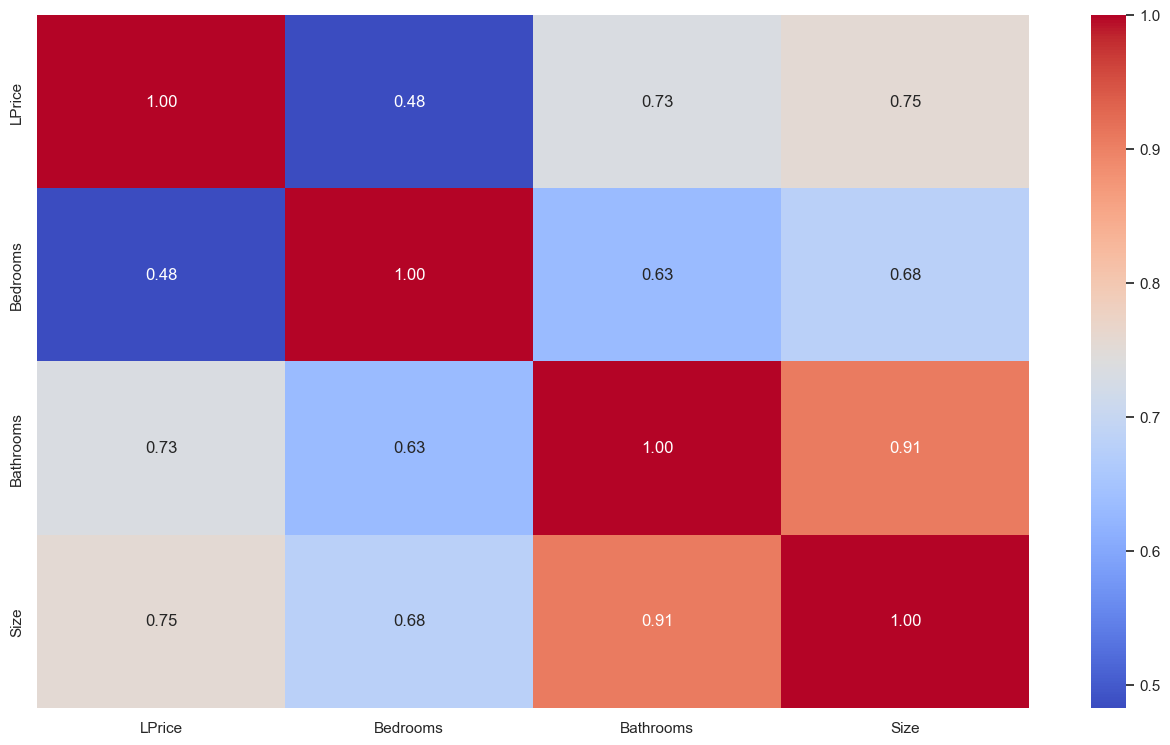

In [54]:
# Select relevant columns
heatmap_data = restate[['LPrice', 'Bedrooms', 'Bathrooms', 'Size']]

# Compute the correlation matrix
correlation_matrix = heatmap_data.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Observations:

- Strong positive correlation between Size and Bathrooms (0.91): This indicates that larger homes tend to have more bathrooms, which is a logical and expected relationship in real estate.

- Moderate to strong correlation between LPrice and Size (0.75): Home size is an important determinant of price, with larger homes generally commanding higher prices.

- Strong correlation between LPrice and Bathrooms (0.73): The number of bathrooms has a substantial positive impact on log-transformed price, slightly less than home size but still significant.

- Weaker correlation between LPrice and Bedrooms (0.48): Surprisingly, the number of bedrooms has a notably lower correlation with log price compared to bathrooms and size. This suggests that in this market, additional bathrooms or square footage may add more value than additional bedrooms.

- Moderate correlation between Bedrooms and Size (0.68) and Bedrooms and Bathrooms (0.63): As expected, homes with more bedrooms tend to be larger and have more bathrooms, but these relationships aren't as strong as the Size-Bathrooms relationship.

- Multicollinearity concerns: The strong correlations between predictor variables (especially Size and Bathrooms) could potentially cause multicollinearity issues in multiple regression models, which might affect the stability of coefficient estimates.


**(b) Produce Boxplots between LPrice and Location and between LPrice and Status. What do you observe? (8 marks)**

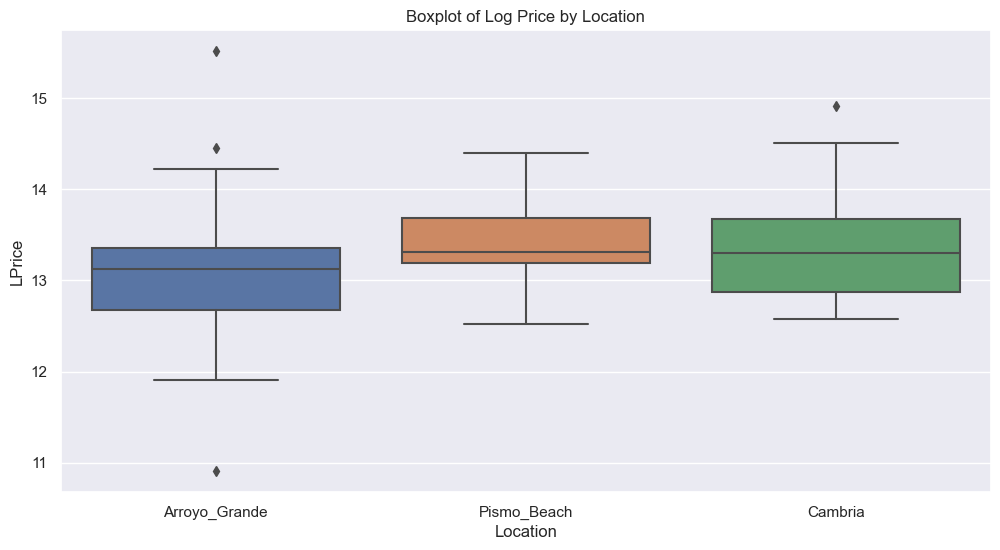

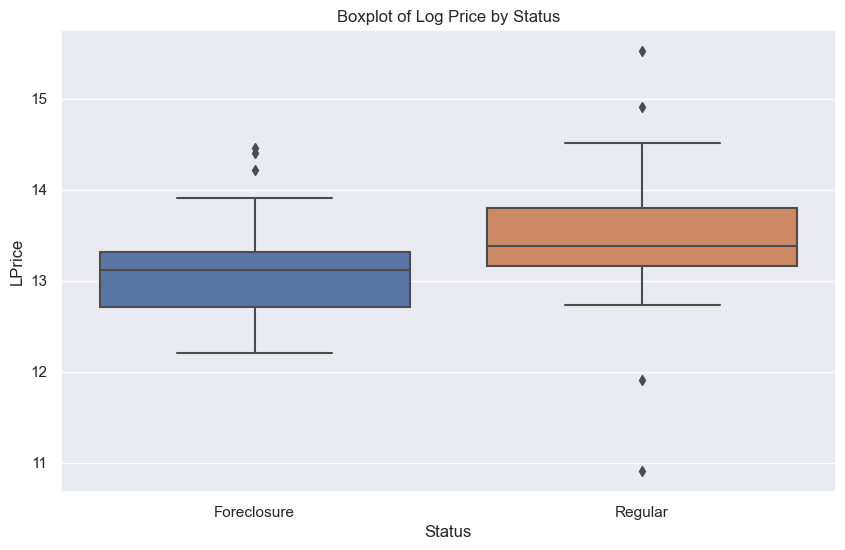

In [55]:
# Boxplot between LPrice and Location
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='LPrice', data=restate)
plt.title('Boxplot of Log Price by Location')
plt.show()

# Boxplot between LPrice and Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='LPrice', data=restate)
plt.title('Boxplot of Log Price by Status')
plt.show()

**Observations:**

Boxplot of Log Price by Location:
1. Median LPrice:

The median log price (LPrice) varies across locations:

- Arroyo Grande has the lowest median log price.

- Pismo Beach has a higher median log price compared to Arroyo Grande.

- Cambria has the highest median log price.

2. Spread of Prices:

- Arroyo Grande has a wider interquartile range (IQR), indicating more variability in prices.

- Pismo Beach and Cambria have smaller IQRs, suggesting more consistency in their log prices.

3. Outliers:

- All three locations have outliers, with Arroyo Grande showing an exceptionally low and high outlier.

- Cambria and Pismo Beach also have some high-end outliers.


**Boxplot of Log Price by Status:**

1. Median LPrice:

- Properties with a regular status have a higher median log price compared to those in foreclosure.
Spread of Prices:

- Foreclosure properties show a narrower IQR, indicating less variability in their prices.

- Regular properties have a wider IQR, reflecting greater variability in prices.

2. Outliers:

- Both foreclosure and regular properties have outliers.

- Regular properties show some particularly high and low outliers, indicating a broader price range.

**Key Insights:**

- Location heavily influences log price, with Cambria tending to have the highest prices and Arroyo Grande the lowest.

- Status also impacts prices, with regular properties generally priced higher than foreclosures.

- Variability and outliers suggest that there are unique factors affecting certain properties' pricing within each group.

**(c) Create dummy variables for Location variable. (2 marks)**

In [36]:
restate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Location     81 non-null     object 
 1   Status       81 non-null     object 
 2   MLS          81 non-null     int64  
 3   Price        81 non-null     int64  
 4   Bedrooms     81 non-null     int64  
 5   Bathrooms    81 non-null     int64  
 6   Size         81 non-null     int64  
 7   LPrice       81 non-null     float64
 8   Foreclosure  81 non-null     int32  
 9   S            81 non-null     int32  
dtypes: float64(1), int32(2), int64(5), object(2)
memory usage: 5.8+ KB


In [59]:
restate = pd.get_dummies(restate, columns=['Location'], drop_first=False)


In [62]:
restate.tail()

,Status,MLS,Price,Bedrooms,Bathrooms,Size,LPrice,S,Location_Arroyo_Grande,Location_Cambria,Location_Pismo_Beach
76,Regular,154539,975000,4,3,2720,13.790193,0,1,0,0
77,Regular,154556,339000,2,2,1440,12.733755,0,0,0,1
78,Regular,154558,849500,3,3,2725,13.652403,0,0,0,1
79,Regular,154575,589000,3,2,1975,13.286181,0,1,0,0
80,Regular,154580,1100000,3,3,2392,13.910821,0,0,1,0


**(d) Fit a regression of LPrice on Bedrooms, Size, S, Location_Arroyo_Grande, Location_Cambria. (4 marks)**

In [120]:
# Fit the model using smf.ols
# Formula specifies the dependent variable (LPrice) and independent variables
model_1 = smf.ols(
    formula="LPrice ~ Bedrooms + Size + S + Location_Arroyo_Grande + Location_Cambria",
    data=restate
).fit()

# Print the regression summary
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 LPrice   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     30.75
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           7.06e-17
Time:                        20:36:32   Log-Likelihood:                -35.584
No. Observations:                  81   AIC:                             83.17
Df Residuals:                      75   BIC:                             97.53
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12

The fitted regression line is 
$$\widehat{\text{LPrice}} = 12.5899 + 0.0184 \cdot \text{Bedrooms} + 0.0005 \cdot \text{Size} - 0.1490 \cdot S - 0.3951 \cdot \text{Location}_{\text{Arroyo\_Grande}} - 0.0407 \cdot \text{Location}_{\text{Cambria}}$$

**(e) Check the regression assumptions. (10 marks)**

In [132]:
#mean of the residuals
residual = se = OLSInfluence(model).resid_studentized_internal

In [134]:
mean_residuals = residual.mean()
print(f"Mean of residuals: {mean_residuals:.10f}")

Mean of residuals: -0.0065327261


Comment. 

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

In [138]:
#Constant Variance

gq_test = sms.het_goldfeldquandt(residual, model.model.exog)

# Print the test results
gq_labels = ['F-statistic', 'p-value', 'Number of observations discarded']
gq_results = dict(zip(gq_labels, gq_test))

print("Goldfeld-Quandt Test Results:")
for key, value in gq_results.items():
    print(f"{key}: {value}")


Goldfeld-Quandt Test Results:
F-statistic: 2.850852521150791
p-value: 0.0013019111234496546
Number of observations discarded: increasing


Comment on the test.

We will use Goldfeld–Quandt test to check homoscedasticity.

- $H_0$ : Residuals are homoscedastic

- $H_1$ : Residuals are hetroscedastic

As we observe from the above test, the p-value is 0.0013, less than 0.05, so we reject the null-hypothesis. That means the residuals are hetroscedastic.

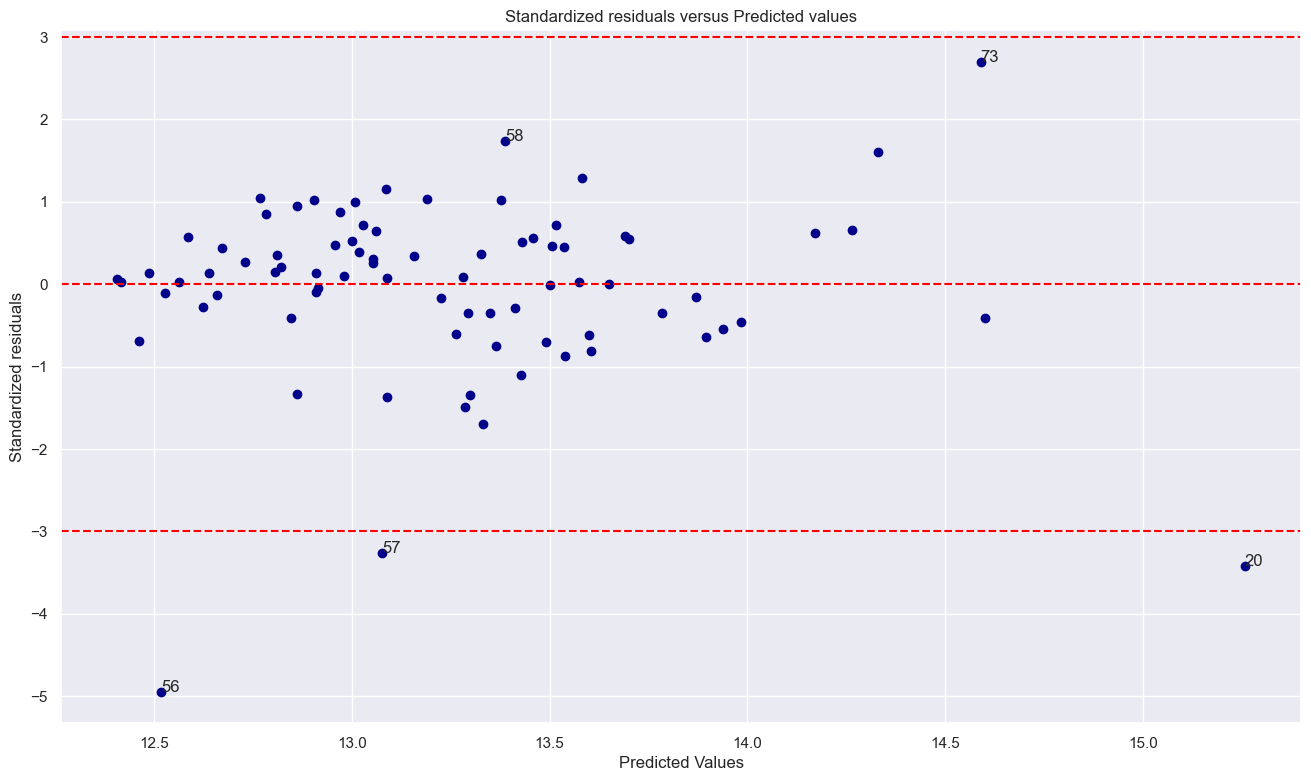

In [131]:
#residual plot

def residual_plot(model,dd=5):
    res = OLSInfluence(model).resid_studentized_external.values
    ares = np.abs(res)
    pY = model.fittedvalues.values
    labels = list(range(len(ares)))
    lpf = [labels[x] for x in np.argsort(ares)]
    erf = [pY[x] for x in np.argsort(ares)]
    spf = [res[x] for x in np.argsort(ares)]
    plt.scatter(pY,res,color='darkblue')
    for c in range(1,dd+1):
        plt.annotate(lpf[-c], (erf[-c], spf[-c]))
    plt.axhline(y=0.0, color='red', linestyle='--')
    plt.axhline(y=3.0, color='red', linestyle='--')
    plt.axhline(y=-3.0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Standardized residuals')
    plt.title('Standardized residuals versus Predicted values')

residual_plot(model_1,dd=5)

Observations:

- We can see that there is no pattern in the residuals vs fitted values scatter plot now, i.e., the linearity assumption is satisfied.

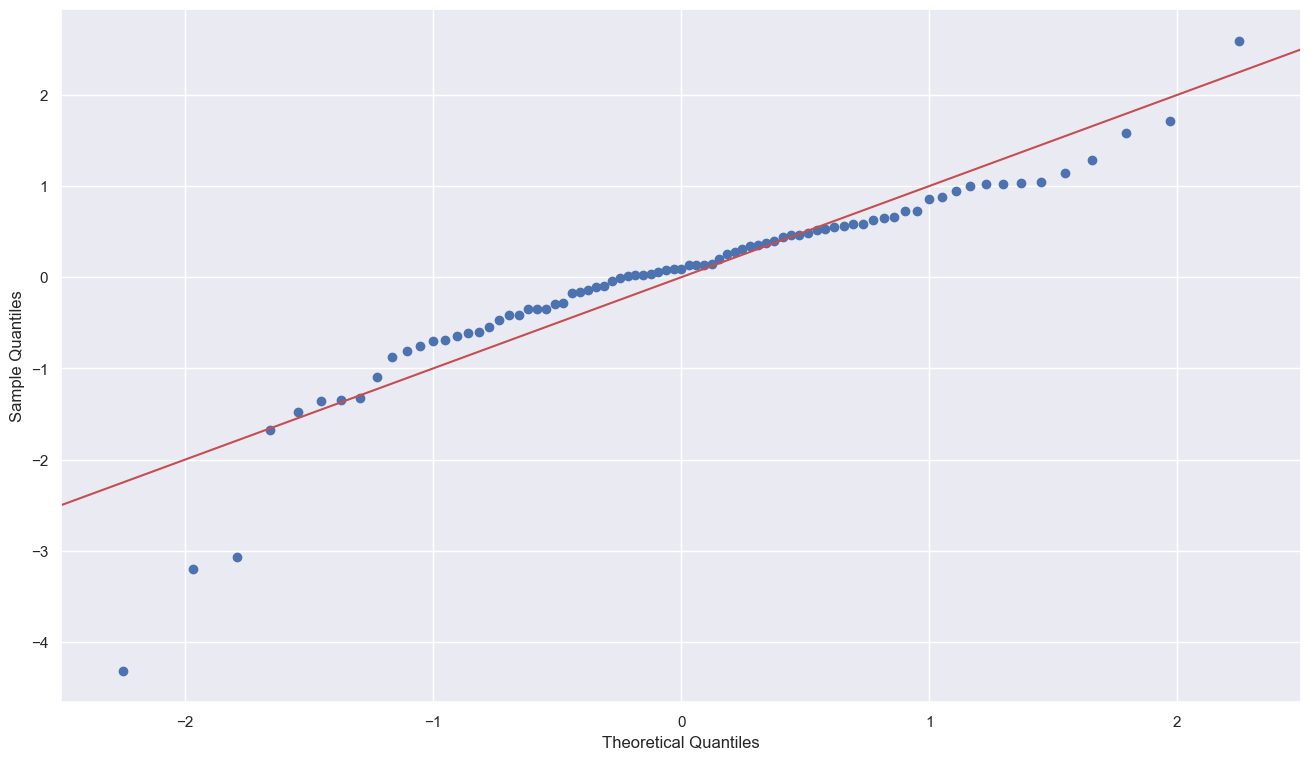

In [144]:
# Plot q-q plot of residuals

sm.qqplot(residual, line ='45')
plt.xlim(-2.5, 2.5)
py.show()

Comment: 
- The residual distribution has heavier tails than a normal distribution would predict (more extreme values), but the residuals are approximately normal.

- While not perfect, the central part of the distribution is reasonably normal, which means standard inferential procedures may still be valid

**(f) Consider a regression model with the predictors $\text{Bedrooms}$, $\text{Bathrooms}$, $\text{Size}$, $\sqrt{\text{Size}}$, $\text{Status}$, $\text{Location}$, $\text{Bedrooms}^{2}$, $\text{Bathrooms}^{2}$ and their 2-way interactions, find the best regression model based on the backward elimination method using SLS=0.05. (10 marks)**

In [175]:
restate['SSize'] = np.sqrt(restate.Size)
restate['Bedrooms2'] = restate.Bedrooms*restate.Bedrooms
restate['Bathrooms2'] = restate.Bathrooms*restate.Bathrooms

In [182]:
def gen_regstring(varlist,Y):
    st = Y+' ~ '
    if len(varlist) > 0:
        st = st+' + '.join(varlist)
    else:
        st = st + '1'
    return st

def cal_p(varlist, depvar, data):
    lm = smf.ols(formula= gen_regstring(varlist,depvar), data = data).fit()
    return lm.pvalues[1:]

def backward_elimination(fulllist, depvar, data, sls=0.05):
    Not_selected_list = []
    selected_list = fulllist
    report = []
    stop = 0
    stage = 0
    while stop==0:
        pvals = cal_p(selected_list,depvar,data).values
        if max(pvals) >= sls:
            s = selected_list[np.argmax(pvals)]
            Not_selected_list.append(s)
            stage = stage+1
            report.append((s,max(pvals),stage))
            selected_list = [x for x in selected_list if x not in Not_selected_list]
        else:
            stop = 1
    output={}
    output['report'] = report
    output['selected'] = selected_list
    return output

In [ ]:
# Define main effects first
main_effects = ['Bedrooms', 'Bathrooms', 'Size', 'SSize', 'S', 
                'Location_Arroyo_Grande', 'Location_Cambria', 'Location_Pismo_Beach', 
                'Bedrooms2', 'Bathrooms2']

# Generate all 2-way interactions
interactions = []
for i in range(len(main_effects)):
    for j in range(i+1, len(main_effects)):
        interactions.append(f"{main_effects[i]}:{main_effects[j]}")
        
# Combine main effects and their interactions
all_vars = main_effects + interactions

print(f"Total number of variables: {len(all_vars)}")
print(f"Number of main effects: {len(main_effects)}")
print(f"Number of interaction terms: {len(interactions)}")

# Run the backward elimination
result = backward_elimination(all_vars, 'LPrice', restate, sls=0.05)

['Bedrooms:Bathrooms',
 'Bedrooms:Size',
 'Bedrooms:SSize',
 'Bedrooms:S',
 'Bedrooms:Location_Arroyo_Grande',
 'Bedrooms:Location_Cambria',
 'Bedrooms:Location_Pismo_Beach',
 'Bedrooms:Bedrooms2',
 'Bedrooms:Bathrooms2',
 'Bathrooms:Size',
 'Bathrooms:SSize',
 'Bathrooms:S',
 'Bathrooms:Location_Arroyo_Grande',
 'Bathrooms:Location_Cambria',
 'Bathrooms:Location_Pismo_Beach',
 'Bathrooms:Bedrooms2',
 'Bathrooms:Bathrooms2',
 'Size:SSize',
 'Size:S',
 'Size:Location_Arroyo_Grande',
 'Size:Location_Cambria',
 'Size:Location_Pismo_Beach',
 'Size:Bedrooms2',
 'Size:Bathrooms2',
 'SSize:S',
 'SSize:Location_Arroyo_Grande',
 'SSize:Location_Cambria',
 'SSize:Location_Pismo_Beach',
 'SSize:Bedrooms2',
 'SSize:Bathrooms2',
 'S:Location_Arroyo_Grande',
 'S:Location_Cambria',
 'S:Location_Pismo_Beach',
 'S:Bedrooms2',
 'S:Bathrooms2',
 'Location_Arroyo_Grande:Location_Cambria',
 'Location_Arroyo_Grande:Location_Pismo_Beach',
 'Location_Arroyo_Grande:Bedrooms2',
 'Location_Arroyo_Grande:Bathroom

In [181]:

BE['selected']


NameError: name 'BE' is not defined

The backward elimination selects the following second-order model



**(g) Using the residuals of the best regression model obtained in Q1.2(f), identify outlier and/or influential cases. (8 marks)**

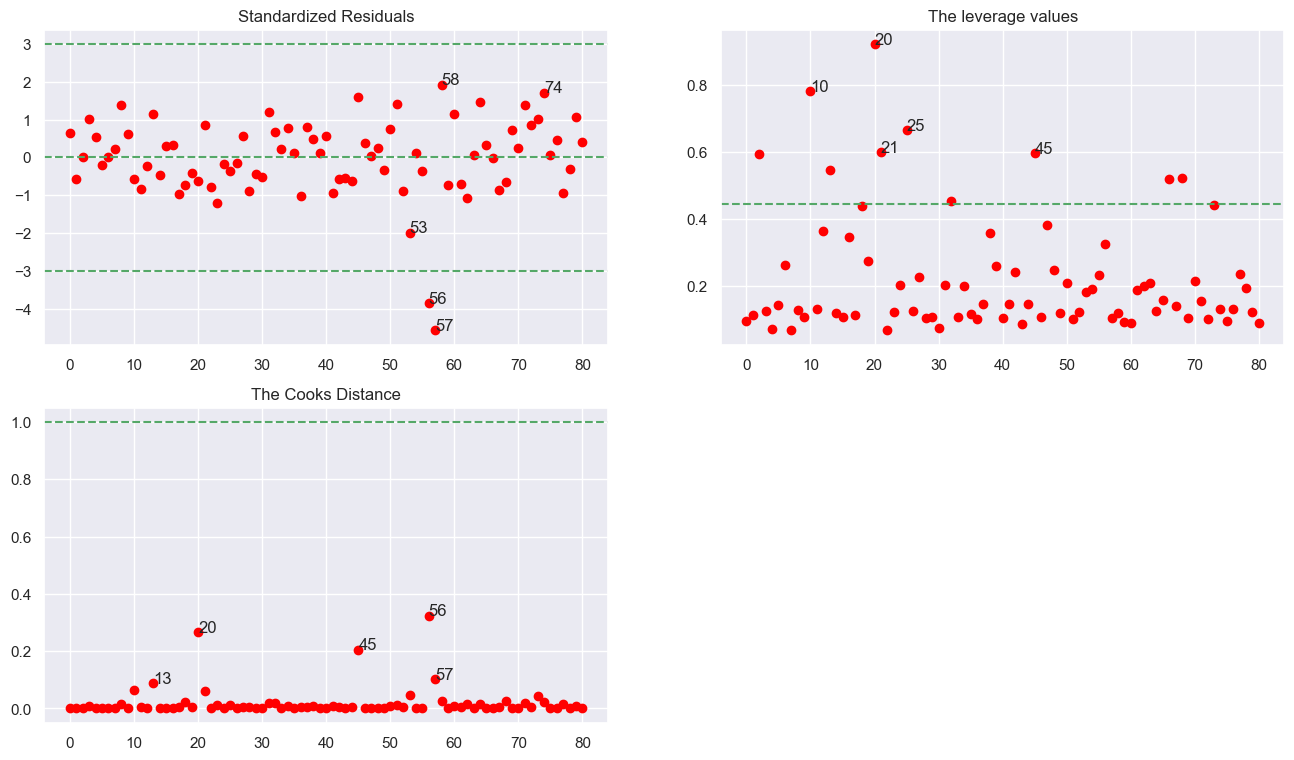

Observations:




**(h) Test, at $5\%$ significance level, whether there is any difference in transaction prices due to difference in the type of sales (Status)? Explain your answer.  Is the conclusion the same as the one obtained in Q1.1(c)? (6 marks)**

In [ ]:
#reduced model

,F-Stat,df1,df2,p-value
0,9.230898,3.000000,63.000000,0.000038


Conclusion of the test:

## Question 2

Consider the data set in data107.csv, which consists of a dependent variable $Y$ and six predictor variables, $X_{l}$, $X_{2}, \ldots, X_{6}$. Analyze the data set for collinearity.

In [213]:
data = pd.read_csv('data107.csv')
data.tail()

,Y,X1,X2,X3,X4,X5,X6
40,29,24,39,24,77,22,6
41,53,90,38,91,65,21,19
42,41,51,90,85,57,30,8
43,32,6,25,60,64,17,0
44,50,82,98,68,56,31,15


**(a) Compute the variance inflation factors for the $X$-variables. Is there any evidence of collinearity? (4 marks)**

In [ ]:
# Calculate VIF for each X-variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

Observation:




**(b) Compute all principal components (PCs) and regress $Y$ on all PCs. Which PCs are significant? (4 marks)**

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     50.92
Date:                Sat, 22 Mar 2025   Prob (F-statistic):           1.14e-16
Time:                        07:23:05   Log-Likelihood:                -126.58
No. Observations:                  45   AIC:                             267.2
Df Residuals:                      38   BIC:                             279.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.0000      0.654     50.467      0.0

Comment:

**(c) Construct the scatter plot of the first two PCs. What would the slope of the least squares regression line describing the relationship between these two PCs be? Why? (4 marks)**

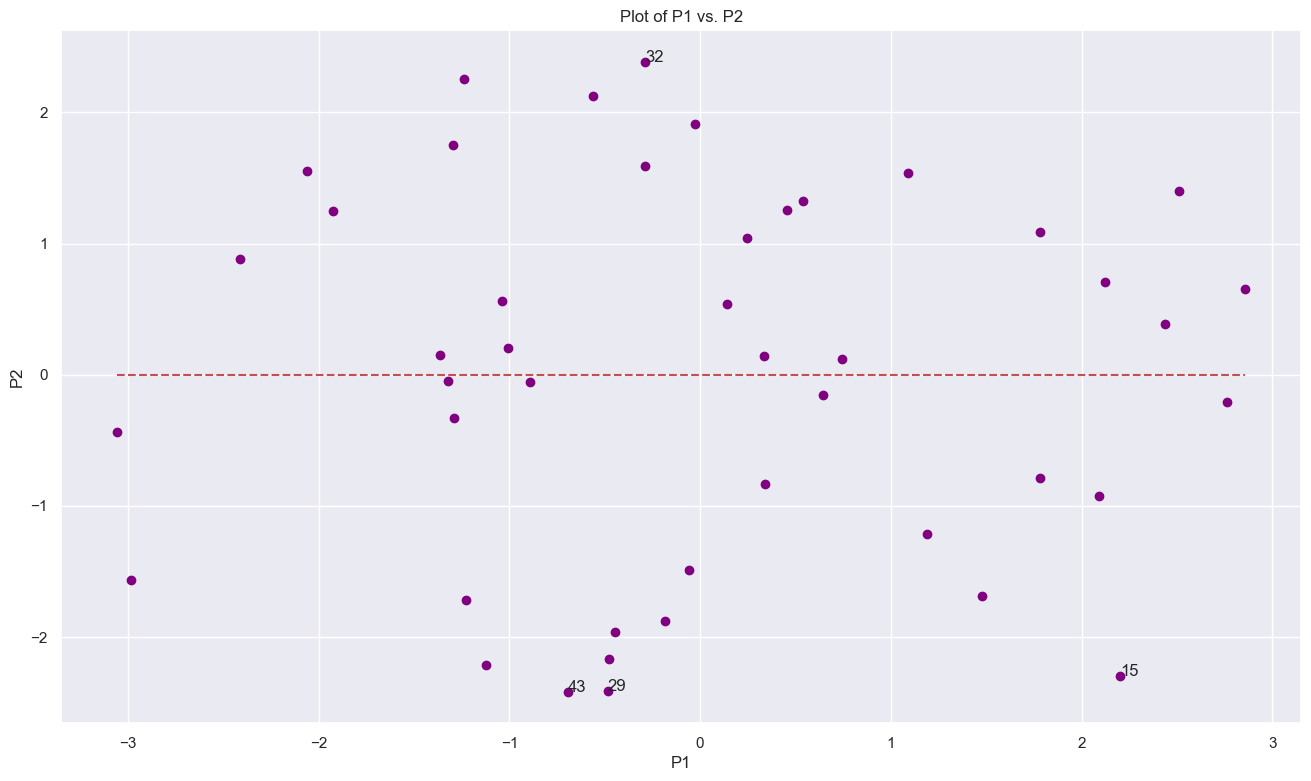

Comment:

**(d) How many sets of collinearity exist in the data? (4 marks)**

Comments:

**(e) Using the lasso method, what value of $\lambda$ do you recommend to be used in the estimation of the parameters in the lasso regression? Use the chosen value of $\lambda$ and compute the lasso estimates of the regression coefficients. (10 marks)**


Use search range between 0.01 and 0.99 and the number of iterations is 1000.

In [ ]:
#The minimum lambda

**Model parameters:**

**The fitted regression line**